# Import relevant libraries for the project

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tqdm

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision.datasets import ImageFolder
from torchvision.transforms import v2, ToTensor, Normalize
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import Grayscale

# Preparation

In [2]:
arch = "ResNet18"

In [3]:
dir_data = './data/'
dir_data_train = dir_data + 'train/'
dir_data_val = dir_data + 'val/'
dir_data_test = dir_data + 'test/'

In [4]:
# BATCH_SIZE = 8
NUM_WORKERS = 0  # dont change this inside of the jupyter notebook (it will crash)
SEED = 42

MODEL_SAVE_PATH = f'./models/{arch}/best_model.pth'

# Classes of images in test dataset
CLASSES = ['ok', 'defective']
N_CLASSES = len(CLASSES)

In [5]:
# Image size for ResNet
img_size = (224, 224)

In [6]:
# Set seed
torch.manual_seed(SEED)

In [7]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("active device:", device)

active device: cuda


In [8]:
# Define Transforms
transform = v2.Compose([
    ToTensor(),
    v2.Resize(img_size, interpolation=v2.InterpolationMode.NEAREST),
    Grayscale(num_output_channels= 1),
    Normalize([0.5], [0.5]),
])

# transform_and_augment = v2.Compose([
#     ToTensor(),
#     v2.Resize(img_size, interpolation=v2.InterpolationMode.NEAREST),
#     Grayscale(num_output_channels= 1),
#     Normalize([0.5], [0.5]),
#     v2.RandomAffine(degrees=15, translate=(0.1, 0.1), fill = 1),  # randomly shift images horizontally/ vertically (fraction of total width/ height)
#     v2.RandomHorizontalFlip(),
# ])

def target_transform(x):
    return F.one_hot(torch.LongTensor([x]), N_CLASSES)[0].float()

In [9]:
# # Load train data
# train_dataset = ImageFolder(root = dir_data_train, transform= transform_and_augment, target_transform= target_transform)
# train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True, num_workers= NUM_WORKERS)

# # Load validation data
# val_dataset = ImageFolder(root = dir_data_val, transform= transform, target_transform= target_transform)
# val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle= True, num_workers= NUM_WORKERS)

# Load test data
test_dataset = ImageFolder(root = dir_data_test, transform= transform, target_transform= target_transform)
test_loader = DataLoader(test_dataset, batch_size= 1, shuffle= False, num_workers= NUM_WORKERS)

In [10]:
# Define the model
class CustomResNet(nn.Module):
    def __init__(self, num_classes= 2, input_channels= 1):
        super(CustomResNet, self).__init__()
        
        # load the pre-trained ResNet model
        self.base_model = resnet18(weights= ResNet18_Weights.DEFAULT)
        
        # change the input channels of the model
        self.base_model.conv1 = nn.Conv2d(
            input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        
        # # Freeze all layers except the last one
        # for param in self.base_model.parameters():
        #     param.requires_grad = False
        
        # change the output layer of the model
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.base_model(x)

In [11]:
model = CustomResNet(num_classes= N_CLASSES, input_channels= 1)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

model = torch.load(MODEL_SAVE_PATH, weights_only= False, map_location= device)

model = model.to(device)
print(model)

CustomResNet(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [12]:
predictions = []
targets = []

with tqdm.tqdm(enumerate(test_loader), total=len(test_loader)) as bar:
    bar.set_description(f"Evaluation")

    model.eval()
    with torch.no_grad():
        for i, data in bar:
            inputs, labels = data

            if device is not None:
                inputs, labels = inputs.to(device= device), labels.to(device= device)

            outputs = model(inputs)

            predictions.append(outputs.squeeze().argmax().item())
            targets.append(labels.squeeze().argmax().item())

Evaluation: 100%|██████████| 1470/1470 [00:37<00:00, 39.17it/s]


In [13]:
# Classification Report
report = classification_report(targets, predictions, output_dict=True)
print(f"For class {CLASSES[0]}:")
print(report["0"])
print(f"For class {CLASSES[1]}:")
print(report["1"])

For class ok:
{'precision': 0.997624703087886, 'recall': 0.997624703087886, 'f1-score': 0.997624703087886, 'support': 842.0}
For class defective:
{'precision': 0.9968152866242038, 'recall': 0.9968152866242038, 'f1-score': 0.9968152866242038, 'support': 628.0}


Confusion Matrix


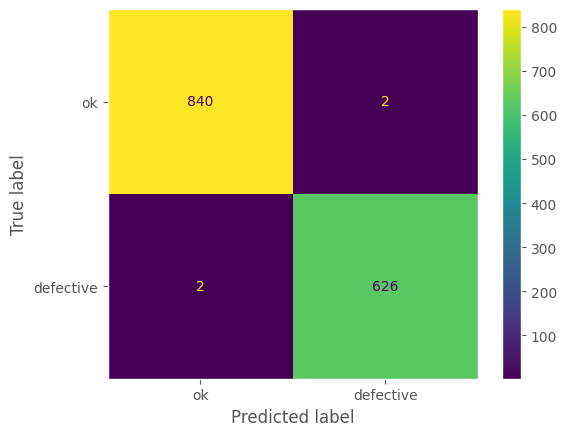

In [14]:
# Confusion Matrix
print('Confusion Matrix')
cm = confusion_matrix(targets, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

disp = disp.plot(include_values = True,
                 values_format = 'd',
                 cmap = 'viridis',
                 ax = None,
                 xticks_rotation = 'horizontal')
plt.grid(False)
plt.show()

In [15]:
# probs = torch.cat([F.softmax(model(inputs.to(device=device)), dim=1)[:, 1].cpu() for inputs, _ in test_loader])
# fpr, tpr, _ = roc_curve(targets, probs)
# roc_auc = auc(fpr, tpr)

# # Plot ROC Curve
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc='lower right')
# plt.show()